# MRO Demand Prediction with LightGBM

In [1]:
# Load data using the pyarrow engine
import pandas as pd
file_name = "./Data/mro_daily_clean.csv"
data = pd.read_csv(file_name, index_col=0, engine="pyarrow")
data

,yr_nbr,mth_nbr,week_nbr,week_day,hard_braking,mild_hb,hard_braking2,harsh_hb,very_harsh_hb,est_hh_incm_prmr_cd,...,mro,record_days,latitude1,longitude1,purchase_lat1,purchase_lng1,purchase_yr_nbr,purchase_mth_nbr,tavg,random_avg_traffic
,,,,,,,,,,,,,,,,,,,,,
0,2019,3,13,7,0,0,0,0,0,6.0,...,0.0,70,45.0,-93.1,45.1,-93.2,2019.0,3.0,14.346983,12472.338289
1,2019,4,14,4,9,0,0,0,0,6.0,...,0.0,70,44.8,-92.9,45.1,-93.2,2019.0,3.0,13.670879,12410.618966
2,2019,4,14,6,9,1,0,0,0,6.0,...,0.0,70,44.8,-92.9,45.1,-93.2,2019.0,3.0,13.699830,12391.577959
3,2019,4,14,7,20,8,0,0,0,6.0,...,0.0,70,45.0,-93.1,45.1,-93.2,2019.0,3.0,13.704561,12313.165404
4,2019,4,15,4,0,0,0,0,0,6.0,...,0.0,70,45.0,-93.1,45.1,-93.2,2019.0,3.0,13.884265,12342.054130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18018968,2019,11,48,5,2,1,0,0,0,9.0,...,1.0,269,42.4,-82.9,42.4,-82.9,2018.0,6.0,12.700000,18816.070000
18018969,2019,12,49,5,1,0,0,0,0,9.0,...,0.0,269,42.4,-82.9,42.4,-82.9,2018.0,6.0,2.200000,6551.590000
18018970,2019,12,50,7,5,1,0,0,0,9.0,...,0.0,269,42.5,-82.9,42.4,-82.9,2018.0,6.0,-2.400000,15358.730000


Split the dataset into 2 part
* 90% for training set and 10% for validation

In [2]:
from sklearn.model_selection import train_test_split

unique_ids = data["id"].unique()

train_ids, val_ids = train_test_split(unique_ids, test_size=0.1, random_state=42)

train_data = data[data["id"].isin(train_ids)]
val_data = data[data["id"].isin(val_ids)]

# Check the lengths of the train and validation sets
print("Length of train_ids:", len(train_ids))
print("Length of val_ids:", len(val_ids))

Length of train_ids: 77652
Length of val_ids: 8628


## Feature Selection

In [3]:
# time features are not relavant for the model (I think)
time_info = ["yr_nbr", "mth_nbr", "week_nbr", "week_day"]
# driver behavior features are needed for the model
driver_behavior = [
    "hard_braking",
    "mild_hb",
    "hard_braking2",
    "harsh_hb",
    "very_harsh_hb",
    "hard_acceleration",
    "mild_ha",
    "harsh_ha",
    "very_harsh_ha",
]
# driver information features
driver_info = [
    "est_hh_incm_prmr_cd",
    "purchaser_age_at_tm_of_purch",
    "input_indiv_gndr_prmr_cd",
]
# vehicle information features
vehicle_info = [
    # "gmqualty_model",
    # "umf_xref_finc_gbl_trim",
    "engn_size",
    # "vin_nbr_id",
]
# speed and mileage features
speed_mileage = ["speeding_sum", "speeding2_sum", "day_mileage"]
# service and maintenance features (target variable)
service_maintenance = [
    # "service_days",
    # "battery_dummy",
    # "brake_dummy",
    # "tire_dummy",
    # "lof_dummy",
    # "wiper_dummy",
    # "filter_dummy",
    # "others",
    "mro",
]
# Record-related Columns
record_related = [
    # "id",
    "day_indicator",
    "record_days",
]

# Geographic information features (not relevant)
geo_info = [
    "latitude1",
    "longitude1",
    "purchase_lat1",
    "purchase_lng1",
]


# Purchase Time-related Columns (not relevant)
purchase_time = [
    "purchase_yr_nbr",
    "purchase_mth_nbr",
]

# External Environment-related Columns (used for prediction)
external_environment = [
    "tavg",
    "random_avg_traffic",
]

In [4]:
full_feature_list = (
    driver_behavior
    + driver_info
    + vehicle_info
    + speed_mileage
    + record_related
    + external_environment
)
target_variable = service_maintenance

In [ ]:
import lightgbm as lgb

X_train = train_data[full_feature_list]
y_train = train_data[target_variable]
X_valid = val_data[full_feature_list]
y_valid = val_data[target_variable]


# make sure all object type columns are converted to category
for col in X_train.select_dtypes(include=["object"]).columns:
    X_train[col] = X_train[col].astype("category")
    X_valid[col] = X_valid[col].astype("category")


train_dataset = lgb.Dataset(X_train, label=y_train)
valid_dataset = lgb.Dataset(X_valid, label=y_valid, reference=train_dataset)

/tmp/ipykernel_837660/3233990223.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype('category')
/tmp/ipykernel_837660/3233990223.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid[col] = X_valid[col].astype('category')


## Model Training

In [6]:
params = {
    "objective": "binary",
    "metric": ["auc", "binary_logloss", "average_precision"],
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 60,
    "max_depth": -1,
    "verbose": -1,
    "device_type": "gpu",
    "bagging_fraction": 0.8,
    "pos_bagging_fraction": 0.8,
    "neg_bagging_fraction": 0.2,
}

In [ ]:
num_round = 1000
bst = lgb.train(
    params,
    train_dataset,
    num_round,
    valid_sets=[valid_dataset],
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[103]	valid_0's auc: 0.681727	valid_0's binary_logloss: 0.0574823	valid_0's average_precision: 0.0377278


## Model Evaluation

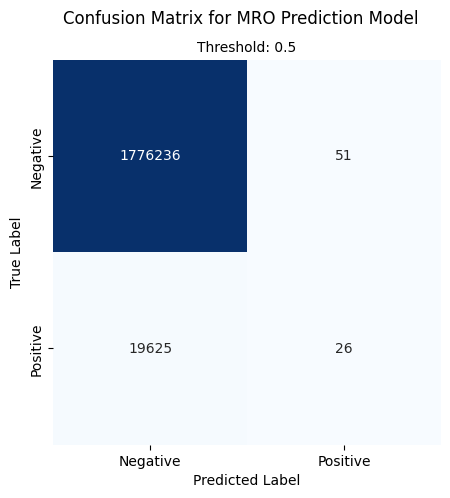

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# get the predicted probabilities
y_pred_prob = bst.predict(X_valid)  # X_valid is the validation set


# set threshold 0.5 to convert probabilities to 0 or 1
threshold = 0.5
y_pred = np.where(y_pred_prob >= threshold, 1, 0)

# compute confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# draw confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"],
    cbar=False,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.suptitle("Confusion Matrix for MRO Prediction Model")
plt.title(f"Threshold: {threshold}", fontsize=10)
plt.show()

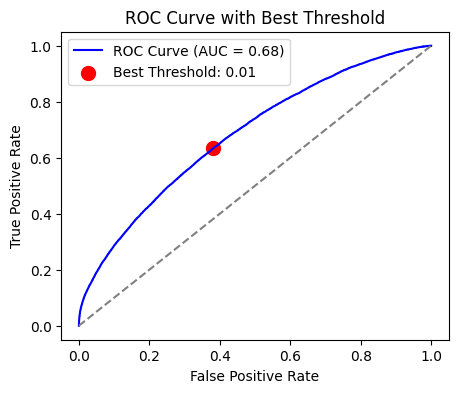

In [53]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_prob)

# compute Youden's J statistic
J = tpr - fpr
best_idx = np.argmax(J)  # find the index of the best threshold
best_threshold = thresholds[best_idx]  # get the best threshold

# draw ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color="blue", label="ROC Curve (AUC = {:.2f})".format(auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # 对角线
plt.scatter(
    fpr[best_idx],
    tpr[best_idx],
    color="red",
    label=f"Best Threshold: {best_threshold:.2f}",
    s=100,
)  # point of best threshold
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Best Threshold")
plt.legend()
plt.show()

# print(f"Best Threshold: {best_threshold:.2f}")

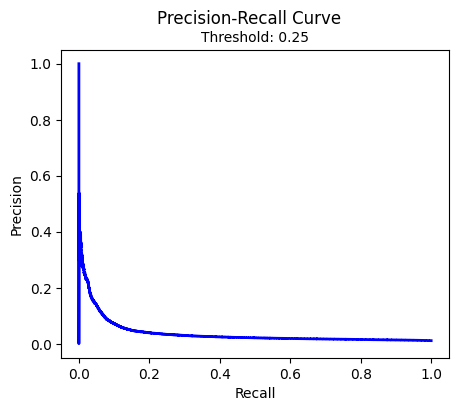

In [45]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_valid, y_pred_prob)

plt.figure(figsize=(5, 4))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.suptitle('Precision-Recall Curve')
plt.title(f"Threshold: {threshold}", fontsize=10)
plt.show()

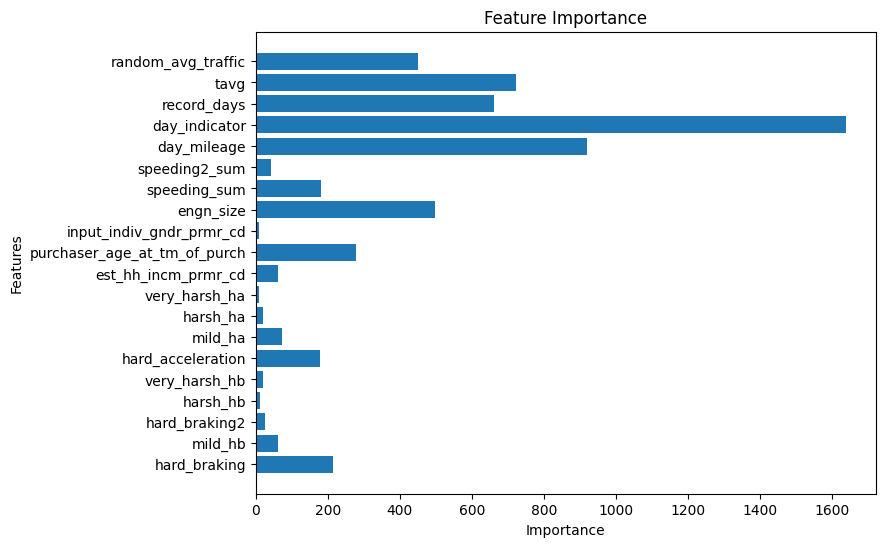

In [ ]:
importances = bst.feature_importance()
feature_names = bst.feature_name()

plt.figure(figsize=(8, 6))
plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

In [8]:
# params = {
#     "objective": "binary",
#     "metric": ["auc", "binary_logloss"],
#     "boosting_type": "gbdt",
#     "learning_rate": 0.05,
#     "num_leaves": 31,
#     "max_depth": -1,
#     "verbose": -1,
#     "device_type": "gpu",
#     "is_unbalance": True,
# }

# Training until validation scores don't improve for 5 rounds
# Early stopping, best iteration is:
# [1]	valid_0's auc: 0.652752	valid_0's binary_logloss: 0.122064

In [9]:
# params = {
#     "objective": "binary",
#     "metric": ["auc", "binary_logloss"],
#     "boosting_type": "gbdt",
#     "learning_rate": 0.05,
#     "num_leaves": 31,
#     "max_depth": -1,
#     "verbose": -1,
#     "device_type": "gpu",
# }

#  Training until validation scores don't improve for 5 rounds
# Early stopping, best iteration is:
# [183]	valid_0's auc: 0.683092	valid_0's binary_logloss: 0.0574817

In [10]:
# params = {
#     "objective": "binary",
#     "metric": ["auc", "binary_logloss"],
#     "boosting_type": "gbdt",
#     "learning_rate": 0.05,
#     "num_leaves": 40,
#     "max_depth": -1,
#     "verbose": -1,
#     "device_type": "gpu",
# }


# Training until validation scores don't improve for 5 rounds
# Early stopping, best iteration is:
# [164]	valid_0's auc: 0.683341	valid_0's binary_logloss: 0.0574758